# **D209 Performance Assessment 2:** Predictive Analysis  

**Student:** Chris Fischer  
**ID:** 011933891  
**Dataset:** Medical  
---

### *Research Question*  

Can we predict how many days a patient's initial hospital stay may be?

## Initialization
---

In [31]:
#import needed libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2, mean_absolute_error as MAE

#allow pd.describe to show all columns of the data frame [In-Text Citation: (Ray, 2020)]
pd.options.display.max_columns = None 

#Initialize some lists to speed cleansing
numerical_variables = ['VitD_levels','Income','Population','Age','Children','Initial_days']
categorical_variables = ['Complication_risk','Area','State']
onehot_variables = ['Gender','Marital','Initial_admin']
yes_no_variables = ['Soft_drink','HighBlood','Stroke','Overweight','Hyperlipidemia','BackPain','Anxiety','Allergic_rhinitis','Reflux_esophagitis','Asthma','Diabetes']

# Explanatory variables
X_full = numerical_variables + categorical_variables + onehot_variables + yes_no_variables
X_vars = X_full.copy()
X_vars.remove('Initial_days')

# Dependent variable
y_vars = 'Initial_days'

#load church_missing_data.csv
df = pd.read_csv('medical_clean.csv', keep_default_na=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

## Cleaning
---

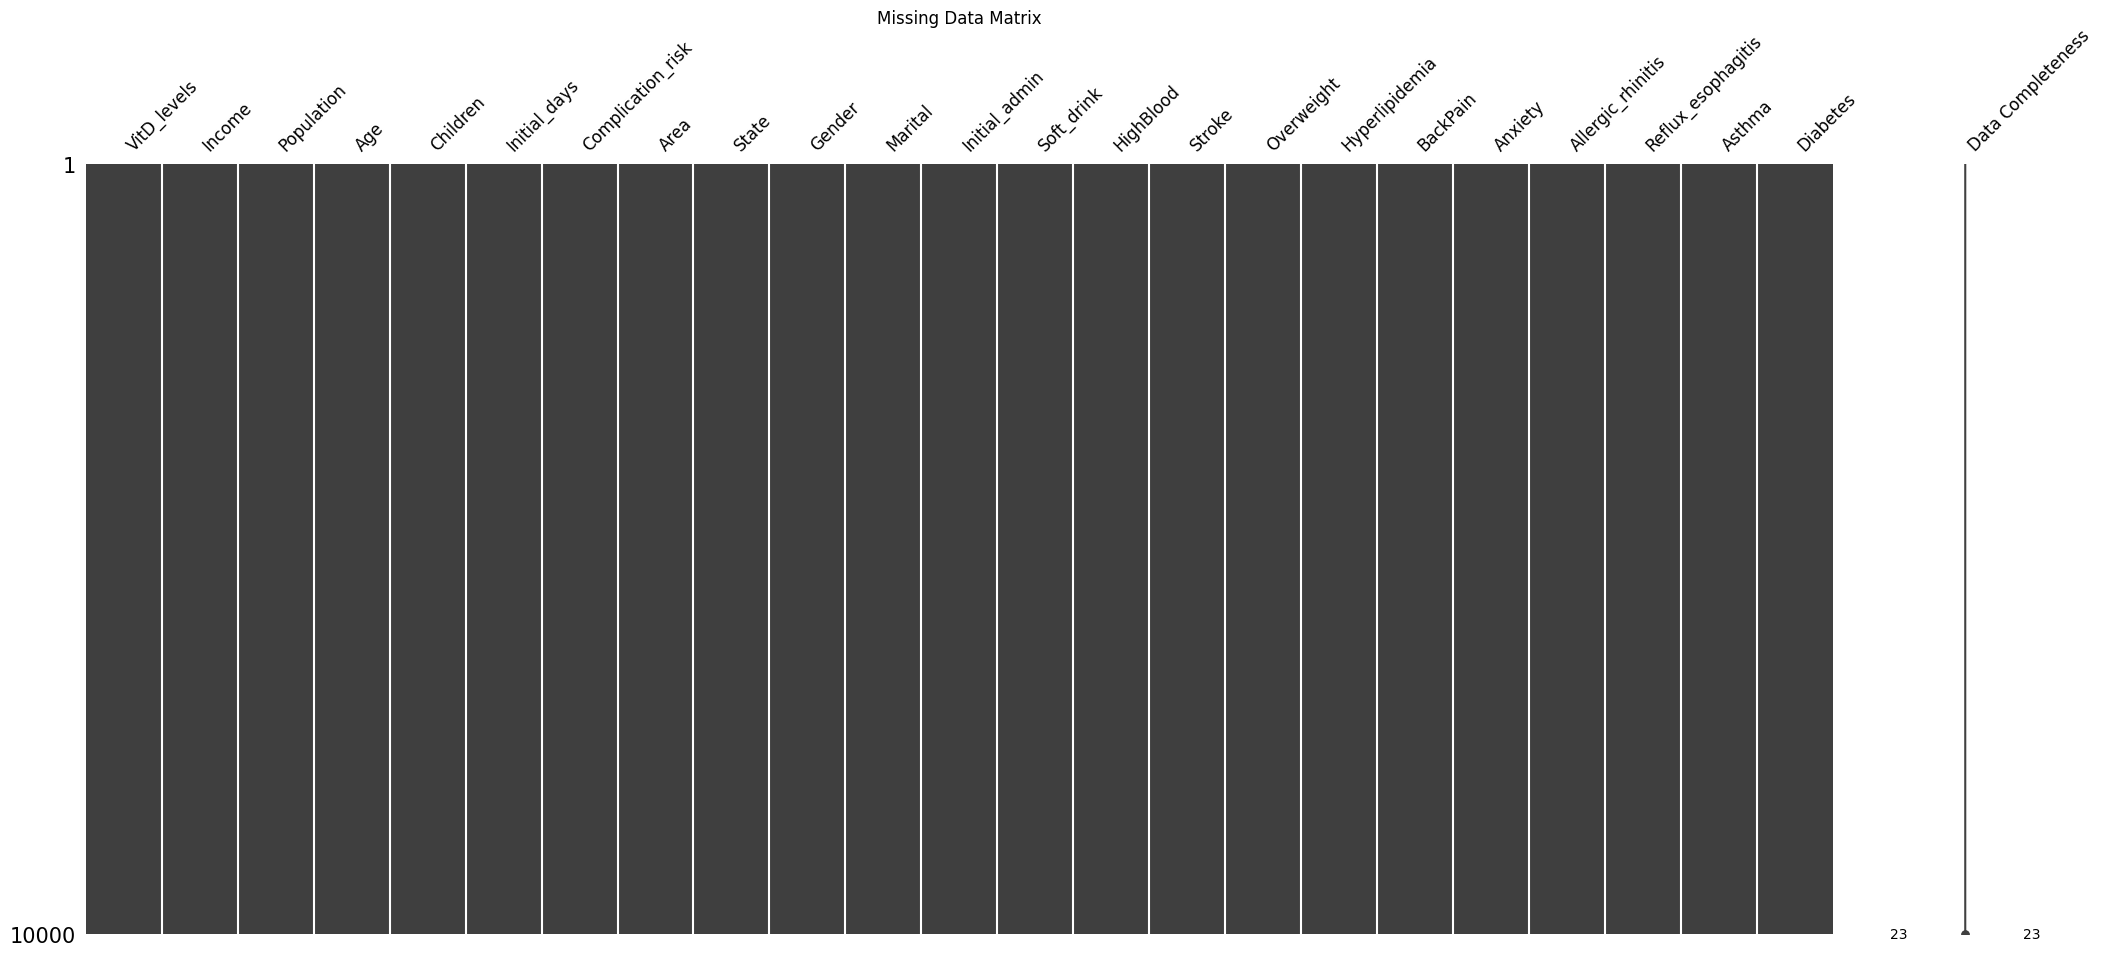

In [32]:
# Check missing data
msno.matrix(df[X_full], fontsize = 12, labels=True)
plt.title('Missing Data Matrix')
plt.show()

In [33]:
#Check values in yes/no variables
print(df[yes_no_variables][~df[yes_no_variables].isin(['Yes','No'])].count())


Soft_drink            0
HighBlood             0
Stroke                0
Overweight            0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Diabetes              0
dtype: int64


In [34]:
#Detect potential outliers
df_z = (df[numerical_variables] - df[numerical_variables].mean())/df[numerical_variables].std(ddof=0)
outlier_cols = df_z.loc[: , (df_z > 3.0).any()].columns
for col in outlier_cols :
    cnt = len(df_z[df_z[col]>3])
    min, max = df[col].min(), df[col].max()
    print('Likely outlier for {0:<20}\t Count: {1:7d} ({2:5.2%} of observations)\tMin: {3:>9.2f}\tMax: {4:>9.2f}'.format(col,cnt,cnt/10000,min,max))

Likely outlier for VitD_levels         	 Count:      14 (0.14% of observations)	Min:      9.81	Max:     26.39
Likely outlier for Income              	 Count:     143 (1.43% of observations)	Min:    154.08	Max: 207249.10
Likely outlier for Population          	 Count:     218 (2.18% of observations)	Min:      0.00	Max: 122814.00
Likely outlier for Children            	 Count:     202 (2.02% of observations)	Min:      0.00	Max:     10.00


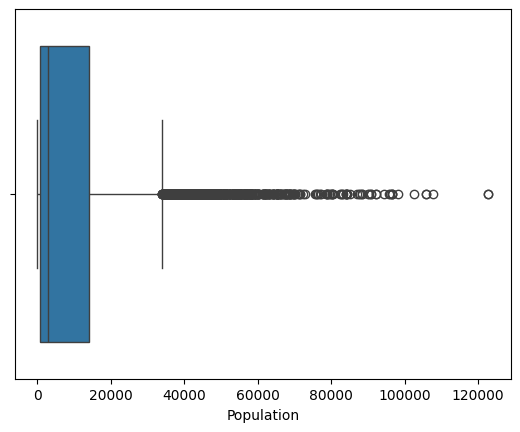

Population
0        109
195       14
115       11
178       11
285       11
        ... 
8092       1
11147      1
27175      1
7371       1
41524      1
Name: count, Length: 5951, dtype: int64


In [35]:
# Deeper look at Population
sns.boxplot(data=df, x='Population')
plt.show()
print(df['Population'].value_counts())

In [36]:
# Drop rows with Population <= 0
df = df[df.Population > 0]
df['Population'].count()

9891

## Transformation
---

In [37]:
# Change "Never Married" to "NeverMarried" to prevent one-hot encoding problems later
df['Marital'] = df['Marital'].replace('\s+', '',regex=True)
print(df['Marital'].value_counts())

Marital
Widowed         2016
Married         1998
Separated       1968
NeverMarried    1961
Divorced        1948
Name: count, dtype: int64


In [38]:
# Reexpress yes/no columns as numbers [In-Text Citation:(Eiler, 2017)]
yesno_dict = {'No': 0, 'Yes': 1}
variables = yes_no_variables
for col in variables:
    df[col] = df[col].map(yesno_dict)
print(df[variables].info())

<class 'pandas.core.frame.DataFrame'>
Index: 9891 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Soft_drink          9891 non-null   int64
 1   HighBlood           9891 non-null   int64
 2   Stroke              9891 non-null   int64
 3   Overweight          9891 non-null   int64
 4   Hyperlipidemia      9891 non-null   int64
 5   BackPain            9891 non-null   int64
 6   Anxiety             9891 non-null   int64
 7   Allergic_rhinitis   9891 non-null   int64
 8   Reflux_esophagitis  9891 non-null   int64
 9   Asthma              9891 non-null   int64
 10  Diabetes            9891 non-null   int64
dtypes: int64(11)
memory usage: 927.3 KB
None


In [39]:
# Rexpress State with frequency encoding [In-Text Citation: (Neural Ninja, 2023)]
df['State'] = df['State'].map(df['State'].value_counts().to_dict())
print(df['State'].info())

# Rexpress Complication_risk with simple ordinal encoding
complication_map = {'Low': 1, 'Medium': 2, 'High' : 3}
df['Complication_risk'] = df['Complication_risk'].map(complication_map)
print(df['Complication_risk'].info())

# Rexpress Area with simple ordinal encoding
area_map = {'Rural': 1, 'Suburban': 2, 'Urban' : 3}
df['Area'] = df['Area'].map(area_map)
print(df['Area'].info())

<class 'pandas.core.series.Series'>
Index: 9891 entries, 0 to 9999
Series name: State
Non-Null Count  Dtype
--------------  -----
9891 non-null   int64
dtypes: int64(1)
memory usage: 154.5 KB
None
<class 'pandas.core.series.Series'>
Index: 9891 entries, 0 to 9999
Series name: Complication_risk
Non-Null Count  Dtype
--------------  -----
9891 non-null   int64
dtypes: int64(1)
memory usage: 154.5 KB
None
<class 'pandas.core.series.Series'>
Index: 9891 entries, 0 to 9999
Series name: Area
Non-Null Count  Dtype
--------------  -----
9891 non-null   int64
dtypes: int64(1)
memory usage: 154.5 KB
None


In [40]:
# One-hot encoding
# [In-Text Citation: (Piepenbreier, 2022)]
preprocessor = make_column_transformer(
 (OneHotEncoder(), onehot_variables ),
  remainder='passthrough',
  verbose_feature_names_out=False
)

X = pd.DataFrame(preprocessor.fit_transform(df[X_vars]), columns=preprocessor.get_feature_names_out())
y = df[y_vars]

In [41]:
# Extract prepared data set to CSV
df_full = pd.concat([X, y], axis=1)
df_full.to_csv('medical_prepared.csv', index=False)

## Modeling
---

In [42]:
# Split data into train and test sets with 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5470)
X_train.to_csv('medical_X_train.csv', index=False)
X_test.to_csv('medical_X_test.csv', index=False)
y_train.to_csv('medical_y_train.csv', index=False)
y_test.to_csv('medical_y_test.csv', index=False)

In [43]:
# Set-up hyperparameter values [In-Text Citation (Koehersen, 2018)] 
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 20)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Set-up base model
rf = RandomForestRegressor()

# Set-up cross validation
rfr = RandomizedSearchCV(estimator=rf, param_distributions=parameters, n_iter=20, cv=5, scoring='neg_mean_squared_error', verbose=1, return_train_score=False, n_jobs=-1)

# Fit the model
rfr.fit(X_train,y_train.values.ravel()) # [In-Text Citation (MacPhee-Cobb, 2016)]
rfr_best = rfr.best_estimator_

# Print results
print('Best score : ' , rfr.best_score_)
print('Best params : ' , rfr.best_params_)
print(rfr_best.get_params())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score :  -690.548386862605
Best params :  {'n_estimators': 66, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 66, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## Model Evaluation
---

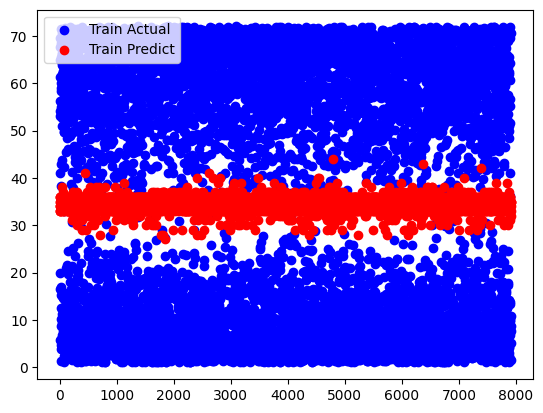

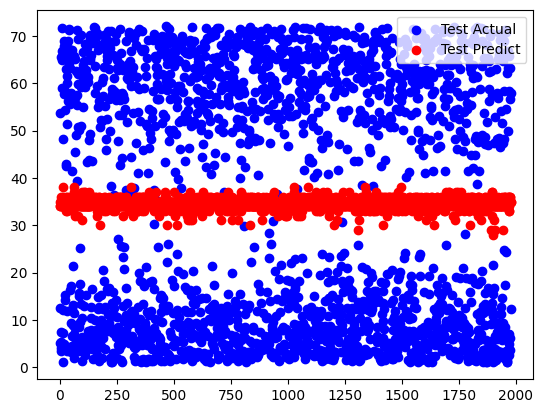

In [44]:
# Compare predicted y vs actual y from the training data set
y_pred_train = rfr_best.predict(X_train)

predictions = np.round(y_pred_train)
plt.scatter(range(len(y_train)), y_train, color='blue', label='Train Actual')
plt.scatter(range(len(predictions)), predictions, color='red', label='Train Predict')
plt.legend()
plt.show()

# Compare predicted y vs actual y from the test data set
y_pred_test = rfr_best.predict(X_test)

predictions = np.round(y_pred_test)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Test Actual')
plt.scatter(range(len(predictions)), predictions, color='red', label='Test Predict')
plt.legend()
plt.show()

In [45]:
# Print some additional metrics
print(f'Training MSE : {MSE(y_train,y_pred_train):.5f}')
print(f'Training MAE : {MAE(y_train,y_pred_train):.5f}')
print(f'Training RMSE: {MSE(y_train,y_pred_train) ** (1/2):.5f}')
print(f'Training R2  : {R2(y_train,y_pred_train):.5f}\n')

print(f'Test MSE : {MSE(y_test,y_pred_test):.5f}')
print(f'Test MAE : {MAE(y_test,y_pred_test):.5f}')
print(f'Test RMSE: {MSE(y_test,y_pred_test) ** (1/2):.5f}')
print(f'Test R2  : {R2(y_test,y_pred_test):.5f}')

Training MSE : 673.17485
Training MAE : 24.84305
Training RMSE: 25.94561
Training R2  : 0.02399

Test MSE : 703.76030
Test MAE : 25.49138
Test RMSE: 26.52848
Test R2  : -0.00301
